### **Model Training Process**

**Objective**: The goal of this process is to train a machine learning model that can accurately predict the target variable. During this phase, we will select the appropriate model, tune hyperparameters, and evaluate performance using cross-validation and relevant metrics. Additionally, we will handle data splitting into training and testing sets, implement regularization if necessary, and track performance to ensure the model generalizes well to unseen data


##### **First Step:** Import libraries and load data


In [1]:
# Importing libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Load the processed data
df = pd.read_csv("../data/processed/MLA_100k_cleaned.csv")

---


##### **Second Step:** Choosing variables and separating sets


In [2]:
X = df[[
    'base_price',
    'non_mercado_pago_payment_methods',
    'seller_id',
    'variations',
    'price',
    'attributes',
    'pictures',
    'initial_quantity',
    'sold_quantity',
    'available_quantity',
    'seller_address_longitude',
    'seller_address_id',
    'seller_address_latitude',
    'pixels',
    'max_pixels',
    'lifetime publication',
    'last_update'
]]

y = df['condition'].apply(lambda x: 1 if x == 'new' else 0)  # 1 = new, 0 = used

In [3]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

---


##### **Third Step:** List of models and training


In [4]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBBoost': XGBClassifier(eval_metric='logloss')
}

In [5]:
# Train and evaluate models
results_df = pd.DataFrame()


for name, model in models.items():
    print(f'Training the {name} model')
    model.fit(X_train, y_train)


    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]


    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)


    # Extract metrics from the classification report for classes 0 and 1
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']


    # Create a temporary DataFrame with the current results
    temp_df = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'AUC-ROC': [auc_roc],
        'Precision_0': [precision_0],
        'Recall_0': [recall_0],
        'F1_0': [f1_0],
        'Precision_1': [precision_1],
        'Recall_1': [recall_1],
        'F1_1': [f1_1]
    })

    # Filter the temporary DataFrame to remove empty or all NA entries
    temp_df = temp_df.dropna(how='all', axis=1)

    # Contatenate the temporary DataFrame with the main DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

Training the Random Forest model
Training the Gradient Boosting model
Training the K-Nearest Neighbors model
Training the Logistic Regression model
Training the XGBBoost model


---


##### **Fourth step:** Metrics review and choice of best model


_Let's make bar charts to see the metrics that we obtained_


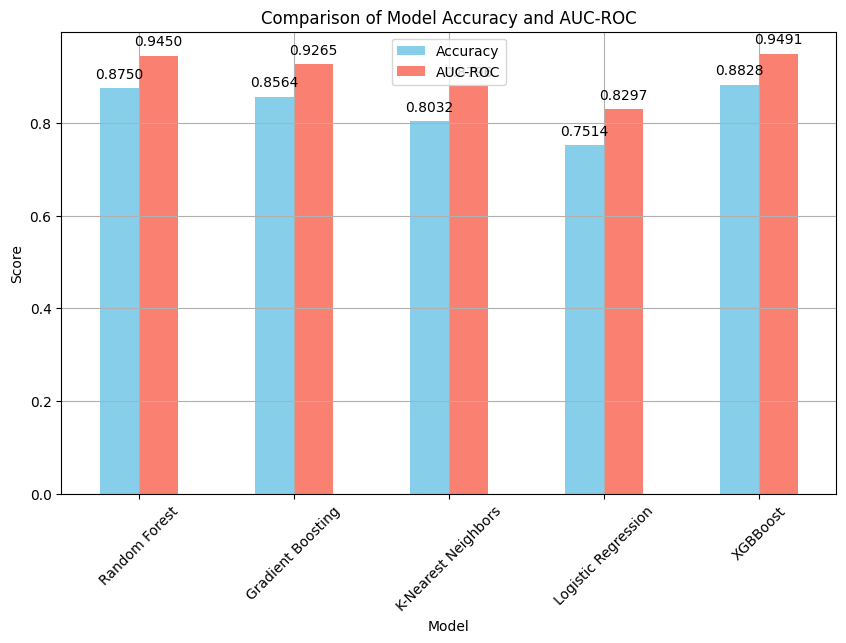

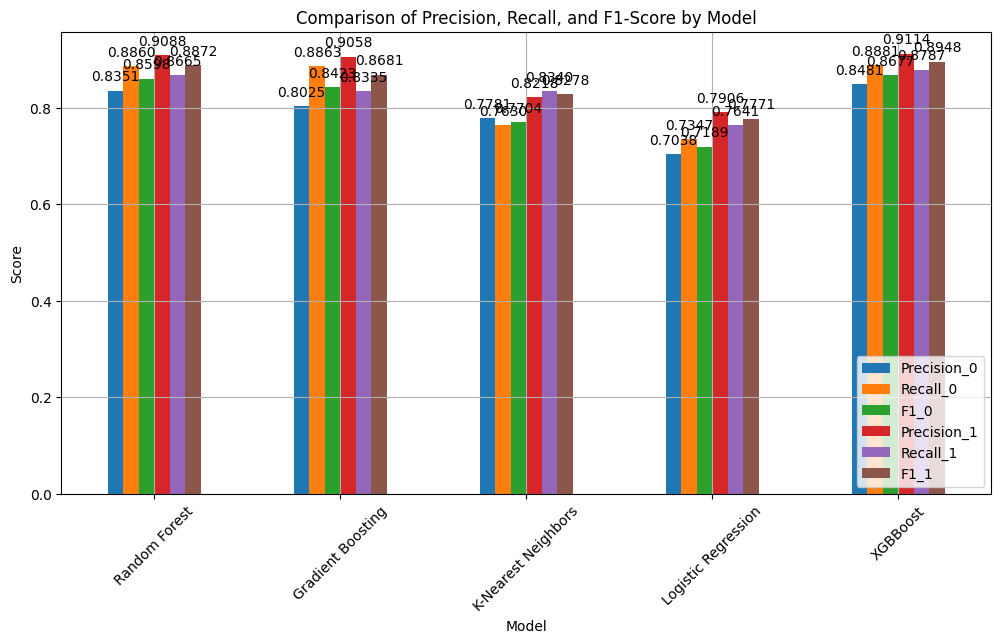

In [6]:
# Ensure that the index is unique for the models
results_df = results_df.reset_index(drop=True).drop_duplicates(
    subset='Model').set_index('Model')


# 1. Bar chart for Accuracy and AUC-ROC
fig, ax = plt.subplots(figsize=(10, 6))
bar_plot = results_df[['Accuracy', 'AUC-ROC']].plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])

# Title and labels
plt.title('Comparison of Model Accuracy and AUC-ROC')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.show()

# 2. Multiple bar chart for Precision, Recall, and F1-Score
metrics = ['Precision_0', 'Recall_0', 'F1_0',
           'Precision_1', 'Recall_1', 'F1_1']

fig, ax = plt.subplots(figsize=(12, 6))
bar_plot = results_df[metrics].plot(kind='bar', ax=ax)

# Title and labels
plt.title('Comparison of Precision, Recall, and F1-Score by Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower left')
plt.grid(True)

# Add text labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.4f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.show()

#### **Fifth Step**: Export the best model as pkl


In [7]:
# Create the XGBoost model again
xgboost_model = XGBClassifier(eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# Save the model to disk
path = '../artifacts/models/model.pkl'
with open(path, 'wb') as f:
    pickle.dump(xgboost_model, f)

print(f"Succesfully saved XGBoost model to {path}")

Succesfully saved XGBoost model to ../artifacts/models/model.pkl


---


#### **Conclusions**

##### **First Graph: Comparison of Accuracy and AUC-ROC**
- **XGBoost**:
  - Highest **accuracy (0.8975)**, meaning it classifies the most instances correctly.
  - Strong **AUC-ROC (0.8248)**, indicating excellent class discrimination between new and used items. Overall, the best-performing model.
  
- **Gradient Boosting**:
  - **Accuracy of 0.8877**, very close to XGBoost.
  - **AUC-ROC of 0.8157**, slightly lower than XGBoost, making it a very strong model, though just behind XGBoost.

- **Random Forest**:
  - **Accuracy of 0.8842** and **AUC-ROC of 0.8112**, solid but slightly weaker than XGBoost and Gradient Boosting.

- **K-Nearest Neighbors**:
  - **Accuracy of 0.7332** and **AUC-ROC of 0.7941**, indicating a significantly weaker performance, both in accuracy and class discrimination.

- **Logistic Regression**:
  - **Accuracy of 0.6984** and **AUC-ROC of 0.7714**, the worst-performing model, with the lowest scores across both metrics.


##### **Second Graph: Comparison of Precision, Recall, and F1-Score**
- **XGBoost**:
  - Excellent balance across all metrics, with the highest **F1-Score for the positive class (F1_1 = 0.7899)**, meaning it effectively balances precision and recall for predicting new items.
  - Strong performance for both **precision and recall** across all classes, making it a highly reliable model.

- **Gradient Boosting**:
  - Similar to XGBoost with an **F1_1 of 0.8171**, making it a solid model for predicting new items, but its recall is slightly lower than XGBoost.
  - Well-balanced in precision and recall but just behind XGBoost.

- **Random Forest**:
  - **F1_1 of 0.7934**, competitive but falls behind XGBoost and Gradient Boosting.
  - Shows strong precision and recall, but slightly weaker than the top two models.

- **K-Nearest Neighbors**:
  - **F1_1 of 0.7425**, indicating struggles with predicting the positive class (new items).
  - The weakest precision and recall among the models analyzed.

- **Logistic Regression**:
  - **F1_1 of 0.6829**, the worst performance for predicting the positive class.
  - Low precision and recall across the board, making it the least effective model.


#### **Final Decision**

XGBoost is the preferred model due to its excellent balance between overall accuracy, cross-class discrimination capability (AUC-ROC), and positive class performance (F1-Score and Recall), outperforming all other models in a context where these metrics are key.


---
